In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [88]:
#Read Argentinian data from APSIM
con = sqlite3.connect(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\0. Calibration\Sorghum_V8.db')
GS0 = pd.read_sql("Select * from PredictedObservedGREENSEEKER",con)
daily0 = pd.read_sql("Select * from DailyReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
GS0.loc[:,'SimulationName'] = [Simulations.loc[GS0.loc[x,'SimulationID'],'Name'] for x in GS0.index]
GS0.set_index('SimulationID',inplace=True)
GS0.drop_duplicates(inplace=True)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
daily0.loc[:,'SimulationName'] = [Simulations.loc[daily0.loc[x,'SimulationID'],'Name'] for x in daily0.index]
daily0.set_index('SimulationID',inplace=True)
daily0.drop_duplicates(inplace=True)

In [89]:
#Clean Argentinian dataframe
GS0.rename(columns={'SimulationName':'SN','Predicted.Das':'Das','Observed.AGBiomass':'AGB_Obs','Predicted.AGBiomass':'AGB_Pre','Observed.AGBiomassError':'AGBError',
                   'Observed.Leaf.CoverGreen':'Cover_Obs','Predicted.Leaf.CoverGreen':'Cover_Pre','Observed.Leaf.CoverGreenError':'CoverError',
                   'Observed.RadInt':'RadInt_Obs','Predicted.RadInt':'RadInt_Pre','Observed.RadIntError':'RadIntError',
                   'Observed.AGGR':'AGGR_Obs', 'Predicted.AGGR':'AGGR_Pre', 'Observed.AGGRError':'AGGRError'}, inplace=True)
GS0.replace(r'^\s+$', np.nan, regex=True)

GS=GS0.drop(['CheckpointID',
       'Pred-Obs.AGBiomass',
       'Pred-Obs.Leaf.CoverGreen',
       'Pred-Obs.RadInt', 'Pred-Obs.AGGR',
       'Predicted.Zone', 'Predicted.Sorghum.AboveGround.Wt',
       'Predicted.Sorghum.AboveGroundDead.Wt',
       'Predicted.Sorghum.AboveGroundLive.Wt', 'Predicted.Leaf.Wt',
       'Predicted.Stem.Wt', 'Predicted.Grain.Wt', 'Predicted.PanicleWt',
       'Predicted.Sorghum.Phenology.FinalLeafNo',
       'Predicted.Sorghum.Leaf.LeafNo', 'Predicted.Leaf.CoverDead',
       'Predicted.Leaf.CoverTotal', 'Predicted.Leaf.SenescedLai',
       'Predicted.Leaf.LAITotal', 'Predicted.Leaf.LAIDead',
       'Predicted.Leaf.LAI', 'Predicted.Leaf.Height',
       'Predicted.Arbitrator.DeltaWt',
       'Predicted.Sorghum.Phenology.FloweringDAS',
       'Predicted.Sorghum.Phenology.MaturityDAS',
       'Predicted.Leaf.ExpansionStress.WaterStressEffect',
       'Predicted.Leaf.ExpansionStress.NitrogenStressEffect',
       'Predicted.Leaf.Photosynthesis.FW', 'Predicted.Leaf.Photosynthesis.FN',
       'Predicted.Leaf.Photosynthesis.RueAct', 'Predicted.Leaf.WaterDemand',
       'Predicted.Leaf.WaterAllocation', 'Predicted.actualET',
       'Predicted.potentialET', 'Predicted.deficitET',
       'Predicted.Sorghum.Leaf.Transpiration', 'Predicted.Soil.SoilWater.Eo',
       'Predicted.Soil.SoilWater.Es',
       'Predicted.SowingDate', 'Predicted.Cultivar', 'Predicted.SowingDepth',
       'Predicted.RowSpacing', 'Predicted.SowDensity',
       'Predicted.Weather.FileName', 'Predicted.Weather.Latitude',
       'Predicted.Weather.Longitude', 'Predicted.Weather.Amp',
       'Predicted.Weather.Tav', 'Predicted.rainfall', 'Predicted.Weather.MinT',
       'Predicted.Weather.MaxT', 'Predicted.radiation',
       'Predicted.Weather.VPD', 'Predicted.Weather.Qmax',
       'Predicted.Leaf.Allocated.Wt', 'Predicted.Stem.Allocated.Wt',
       'Predicted.Grain.Allocated.Wt', 'Predicted.Rachis.Allocated.Wt',
       'Predicted.Root.Allocated.Wt', 'Predicted.Trate', 'Predicted.PAWC'],axis=1)



daily0.rename(columns={'SimulationName':'SN','Leaf.CoverGreen':'Cover_Sim','AGBiomass':'AGB_Sim','RadInt':'RadInt_Sim',
                       'AGGR':'AGGR_Sim','Clock.Today':'date','Leaf.Photosynthesis.RueAct':'RUE_Sim','Weather.MaxT':'tmax', 'Weather.MinT':'tmin',
                      'radiation':'radn','rainfall':'rain'}, inplace=True)

daily0.replace(r'^\s+$', np.nan, regex=True)

daily=daily0.drop(['CheckpointID', 'Zone',
       'Sorghum.AboveGround.Wt', 'Sorghum.AboveGroundDead.Wt',
       'Sorghum.AboveGroundLive.Wt', 'Leaf.Wt', 'Stem.Wt', 'Grain.Wt',
       'PanicleWt', 'Sorghum.Phenology.FinalLeafNo', 'Sorghum.Leaf.LeafNo',
       'Leaf.CoverDead', 'Leaf.CoverTotal', 'Leaf.SenescedLai', 'Leaf.LAITotal', 'Leaf.LAIDead', 'Leaf.LAI',
       'Leaf.Height', 'Arbitrator.DeltaWt', 'Sorghum.Phenology.FloweringDAS',
       'Sorghum.Phenology.MaturityDAS', 'Leaf.ExpansionStress.WaterStressEffect',
       'Leaf.ExpansionStress.NitrogenStressEffect', 'Leaf.Photosynthesis.FW',
       'Leaf.Photosynthesis.FN', 'Leaf.WaterDemand', 'Leaf.WaterAllocation', 'actualET', 'deficitET',
       'Sorghum.Leaf.Transpiration', 'Soil.SoilWater.Eo', 'Soil.SoilWater.Es',
       'Cultivar', 'SowingDepth',
       'Weather.FileName', 'Weather.Latitude', 'Weather.Longitude',
       'Weather.Amp', 'Weather.Tav', 'Weather.VPD', 'Weather.Qmax', 'Leaf.Allocated.Wt', 'Stem.Allocated.Wt',
       'Grain.Allocated.Wt', 'Rachis.Allocated.Wt', 'Root.Allocated.Wt', 'Trate'],axis=1)

daily['climate'] = daily['SN'].str[:6]
daily['soil'] = daily['SN'].str[7:11]
daily['cultivar'] = daily['SN'].str[12:15]
daily['harvest'] = daily['SN'].str[16:18]
daily['prevcrop'] = daily['SN'].str[19:20]

Obs=GS.drop(['AGB_Pre','AGGR_Pre','Cover_Pre','RadInt_Pre'],axis=1) 
Obs.rename(columns={'Clock.Today':'date'}, inplace=True)

df_final0 = daily.merge(Obs, on=['SN','date'], how = 'outer')
df_final0['tmean'] = (df_final0['tmin'] + df_final0['tmax']) / 2
df_final0.rename(columns={'Das_x':'Das','AGB_Sim':'AGB_Pre','Cover_Sim':'Cover_Pre','RadInt_Sim':'RadInt_Pre','AGGR_Sim':'AGGR_Pre',
                         'RUE_Sim':'RUE_Pre'}, inplace=True)
df_final=df_final0.drop(['Das_y'],axis=1)

agbArge=df_final.dropna(subset=['AGB_Obs'])
agbArg=agbArge.drop(['Predicted.Sorghum.Phenology.Stage','Predicted.Sorghum.Phenology.CurrentPhaseName','Sorghum.Phenology.Stage',
       'Sorghum.Phenology.CurrentPhaseName'],axis=1)
agbArg['country'] = 'Argentina' 

cov=df_final.dropna(subset=['Cover_Obs'])
cov['env'] = cov['climate'] + "_" + cov['soil']
rad=df_final.dropna(subset=['RadInt_Obs'])
rad['env'] = rad['climate'] + "_" + rad['soil']

<ipython-input-89-a27af4750b97>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cov['env'] = cov['climate'] + "_" + cov['soil']
<ipython-input-89-a27af4750b97>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad['env'] = rad['climate'] + "_" + rad['soil']


In [118]:
#df_final.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\df.csv', index=None, mode='a')

In [76]:
#Read Australian data from APSIM
con = sqlite3.connect(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\0. Calibration\Sorghum_V8_Australia.db')
OBS = pd.read_sql("Select * from PredictedObservedAustralia",con)
daily00 = pd.read_sql("Select * from DailyReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
OBS.loc[:,'SimulationName'] = [Simulations.loc[OBS.loc[x,'SimulationID'],'Name'] for x in OBS.index]
OBS.set_index('SimulationID',inplace=True)
OBS.drop_duplicates(inplace=True)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
daily00.loc[:,'SimulationName'] = [Simulations.loc[daily00.loc[x,'SimulationID'],'Name'] for x in daily00.index]
daily00.set_index('SimulationID',inplace=True)
daily00.drop_duplicates(inplace=True)

In [77]:
#Clean Australian dataframe
OBS.rename(columns={'SimulationName':'SN','Predicted.Das':'Das','Observed.AGBiomass':'AGB_Obs','Predicted.AGBiomass':'AGB_Pre'}, inplace=True)
OBS.replace(r'^\s+$', np.nan, regex=True)

GS=OBS.drop(['CheckpointID',
       'Pred-Obs.AGBiomass',
       'Predicted.Zone', 'Predicted.Sorghum.AboveGround.Wt',
       'Predicted.Sorghum.AboveGroundDead.Wt',
       'Predicted.Sorghum.AboveGroundLive.Wt', 'Predicted.Leaf.Wt',
       'Predicted.Stem.Wt', 'Predicted.Grain.Wt', 'Predicted.PanicleWt',
       'Predicted.Sorghum.Phenology.FinalLeafNo',
       'Predicted.Sorghum.Leaf.LeafNo', 'Predicted.Leaf.CoverDead',
       'Predicted.Leaf.CoverTotal', 'Predicted.Leaf.SenescedLai',
       'Predicted.Leaf.LAITotal', 'Predicted.Leaf.LAIDead',
       'Predicted.Leaf.LAI', 'Predicted.Leaf.Height',
       'Predicted.Arbitrator.DeltaWt',
       'Predicted.Sorghum.Phenology.FloweringDAS',
       'Predicted.Sorghum.Phenology.MaturityDAS',
       'Predicted.Leaf.ExpansionStress.WaterStressEffect',
       'Predicted.Leaf.ExpansionStress.NitrogenStressEffect',
       'Predicted.Leaf.Photosynthesis.FW', 'Predicted.Leaf.Photosynthesis.FN',
       'Predicted.Leaf.Photosynthesis.RueAct', 'Predicted.Leaf.WaterDemand',
       'Predicted.Leaf.WaterAllocation', 'Predicted.actualET',
       'Predicted.potentialET', 'Predicted.deficitET',
       'Predicted.Sorghum.Leaf.Transpiration', 'Predicted.Soil.SoilWater.Eo',
       'Predicted.Soil.SoilWater.Es',
       'Predicted.SowingDate', 'Predicted.Cultivar', 'Predicted.SowingDepth',
       'Predicted.RowSpacing', 'Predicted.SowDensity',
       'Predicted.Weather.FileName', 'Predicted.Weather.Latitude',
       'Predicted.Weather.Longitude', 'Predicted.Weather.Amp',
       'Predicted.Weather.Tav', 'Predicted.rainfall', 'Predicted.Weather.MinT',
       'Predicted.Weather.MaxT', 'Predicted.radiation',
       'Predicted.Weather.VPD', 'Predicted.Weather.Qmax',
       'Predicted.Leaf.Allocated.Wt', 'Predicted.Stem.Allocated.Wt',
       'Predicted.Grain.Allocated.Wt', 'Predicted.Rachis.Allocated.Wt',
       'Predicted.Root.Allocated.Wt', 'Predicted.Trate', 'Predicted.PAWC','Predicted.Leaftnha',
       'Predicted.Leaf.CoverGreen', 'Predicted.RadInt',
       'Predicted.Sorghum.Phenology.CurrentStageName',
       'Predicted.Sorghum.Phenology.Stage', 'Predicted.AGGR'],axis=1)

daily00.rename(columns={'SimulationName':'SN','AGBiomass':'AGB_Sim','Clock.Today':'date','Leaf.Photosynthesis.RueAct':'RUE_Sim','Weather.MaxT':'tmax', 'Weather.MinT':'tmin',
                      'radiation':'radn','rainfall':'rain'}, inplace=True)

daily00.replace(r'^\s+$', np.nan, regex=True)

dailyAu=daily00.drop(['CheckpointID', 'Zone',
       'Sorghum.AboveGround.Wt', 'Sorghum.AboveGroundDead.Wt',
       'Sorghum.AboveGroundLive.Wt', 'Leaf.Wt', 'Stem.Wt', 'Grain.Wt',
       'PanicleWt', 'Sorghum.Phenology.FinalLeafNo', 'Sorghum.Leaf.LeafNo',
       'Leaf.CoverDead', 'Leaf.CoverTotal',
       'Leaf.SenescedLai', 'Leaf.LAITotal', 'Leaf.LAIDead', 'Leaf.LAI',
       'Leaf.Height', 'Arbitrator.DeltaWt', 'Sorghum.Phenology.FloweringDAS',
       'Sorghum.Phenology.MaturityDAS',
       'Leaf.ExpansionStress.WaterStressEffect',
       'Leaf.ExpansionStress.NitrogenStressEffect', 'Leaf.Photosynthesis.FW',
       'Leaf.Photosynthesis.FN', 'Leaf.WaterDemand',
       'Leaf.WaterAllocation', 'actualET', 'deficitET',
       'Sorghum.Leaf.Transpiration', 'Soil.SoilWater.Eo', 'Soil.SoilWater.Es',
       'Cultivar', 'SowingDepth',
       'Weather.FileName', 'Weather.Latitude', 'Weather.Longitude',
       'Weather.Amp', 'Weather.Tav',
       'Weather.VPD', 'Weather.Qmax', 'Leaf.Allocated.Wt', 'Stem.Allocated.Wt',
       'Grain.Allocated.Wt', 'Rachis.Allocated.Wt', 'Root.Allocated.Wt', 'Trate'],axis=1)

dailyAu['climate'] = dailyAu['SN'].str[:6]
dailyAu['soil'] = dailyAu['SN'].str[7:11]
dailyAu['cultivar'] = dailyAu['SN'].str[12:15]
dailyAu['harvest'] = dailyAu['SN'].str[16:18]
dailyAu['prevcrop'] = dailyAu['SN'].str[19:20]

Obs=GS.drop(['AGB_Pre'],axis=1) 
Obs.rename(columns={'Clock.Today':'date'}, inplace=True)

df_finalAu = dailyAu.merge(Obs, on=['SN','date'], how = 'outer')
df_finalAu['tmean'] = (df_finalAu['tmin'] + df_finalAu['tmax']) / 2
df_finalAu.rename(columns={'Das_x':'Das','AGB_Sim':'AGB_Pre','RUE_Sim':'RUE_Pre'}, inplace=True)
df_finalAus2=df_finalAu.drop(['Das_y'],axis=1)
df_finalAus = df_finalAus2.where(df_finalAus2['Das'] != 0)

agbAus=df_finalAus.dropna(subset=['AGB_Obs'])
agbAu=agbAus.drop(['Leaftnha', 'Leaf.CoverGreen', 'RadInt', 'Sorghum.Phenology.CurrentStageName', 'Sorghum.Phenology.Stage', 'AGGR'],axis=1)
agbAu['country'] = 'Australia' 

In [53]:
#Arrange both dataframes to put all agb data together
#agbArg.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\agbArg.csv', index=None, mode='a')
#agbAu.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\agbAu.csv', index=None, mode='a')

In [82]:
#Read the agb data for both countries
agb=pd.read_csv(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\Python\agbAll.csv')
agb['env'] = agb['climate'] + "_" + agb['soil']

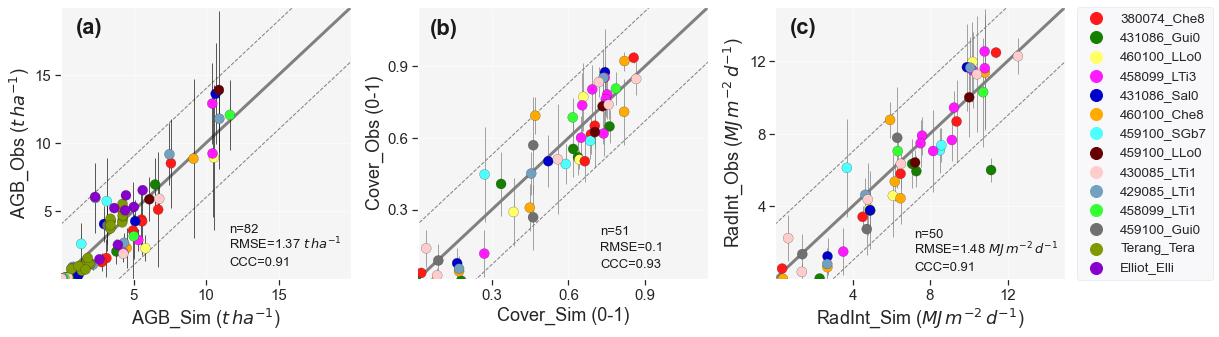

In [102]:
colors=['#FF1919','#158000','#FFFF66','#FF19FF','#0000CC','#FFAA00','#4DFFFF','#660000','#FFCCCC','#72A0C1','#33FF33','#707070','#7F9900',
        '#8800CC']
colors2=['#FF1919','#158000','#FFFF66','#FF19FF','#0000CC','#FFAA00','#4DFFFF','#660000','#FFCCCC','#72A0C1','#33FF33','#707070']

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(18,5))

ax=plt.subplot(1, 3, 1)
xmax=19.99
ymax=19.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[4,ymax+4],"--",color="grey", linewidth=1,zorder=1)
plt.plot([4,xmax+4],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(agb['AGB_Pre'], agb['AGB_Obs'], yerr = agb['AGBError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="AGB_Pre", y="AGB_Obs",hue='env', alpha=1,data=agb,linewidth=0.2,**kwargs,s=100,zorder=3, 
                markers=filled_markers,palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=13.5),bbox_to_anchor=(3.5, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('AGB_Obs ($t\,ha^{-1}$)', fontsize =18)
plt.xlabel('AGB_Sim ($t\,ha^{-1}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(agb.AGB_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(agb.AGB_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.58, ymax*0.17,'n='+N,fontsize=13,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.58, ymax*0.11,'RMSE='+RMSE+' $t\,ha^{-1}$',fontsize=13,color='k')
plt.text(xmax*0.58, ymax*0.05,'CCC='+CCC,fontsize=13,color='k')
#plt.text(xmax*0.60, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
ax=plt.subplot(1, 3, 2) 
xmax=1.15
ymax=1.15
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[0.23,ymax+0.23],"--",color="grey", linewidth=1,zorder=1)
plt.plot([0.23,xmax+0.23],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(cov['Cover_Pre'], cov['Cover_Obs'], yerr = cov['CoverError'], fmt ='o',marker='',zorder=2,color='grey',linewidth=0.7)
sns.scatterplot(x="Cover_Pre", y="Cover_Obs",hue='env', alpha=1,data=cov,linewidth=0.2,**kwargs,s=100,zorder=3,
                markers=filled_markers,palette=colors2)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(2.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('Cover_Obs (0-1)', fontsize =18)
plt.xlabel('Cover_Sim (0-1)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(cov.Cover_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(cov.Cover_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(b)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.63, ymax*0.17,'n='+N,fontsize=13,color='k')
#plt.text(xmax*0.65, ymax*0.2,'MSE='+MSE+'',fontsize=11,color='k')
plt.text(xmax*0.63, ymax*0.11,'RMSE='+RMSE+'',fontsize=13,color='k')
plt.text(xmax*0.63, ymax*0.05,'CCC='+CCC,fontsize=13,color='k')
#plt.text(xmax*0.65, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
ax=plt.subplot(1, 3, 3)
xmax=14.99
ymax=14.99
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[3,ymax+3],"--",color="grey", linewidth=1,zorder=1)
plt.plot([3,xmax+3],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
ax.errorbar(rad['RadInt_Pre'], rad['RadInt_Obs'], yerr = rad['RadIntError'], fmt ='o',marker='',zorder=2,color='grey',linewidth=0.7)
sns.scatterplot(x="RadInt_Pre", y="RadInt_Obs",hue='env', alpha=1,data=rad,linewidth=0.2,**kwargs,s=100,zorder=3,
                markers=filled_markers,palette=colors2)


# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(2.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('RadInt_Obs ($MJ\,m^{-2}\,d^{-1}$)', fontsize =18)
plt.xlabel('RadInt_Sim ($MJ\,m^{-2}\,d^{-1}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(rad.RadInt_Obs.values)
y_o= Obs.tolist()
Pre = pd.Series(rad.RadInt_Pre.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.9,'(c)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.48, ymax*0.15,'n='+N,fontsize=13,color='k')
#plt.text(xmax*0.55, ymax*0.2,'MSE='+MSE+' $MJ\,m^{-2}\,d^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.48, ymax*0.09,'RMSE='+RMSE+' $MJ\,m^{-2}\,d^{-1}$',fontsize=13,color='k')
plt.text(xmax*0.48, ymax*0.03,'CCC='+CCC,fontsize=13,color='k')
#plt.text(xmax*0.55, ymax*0.05,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.23, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\obsvspre1.png', dpi=300,bbox_inches='tight')

In [105]:
#Preparing daily data to be plotted
#df_final = df_final[df_final.Das != 0]
#df_finalAus = df_finalAus[df_finalAus.Das != 0]

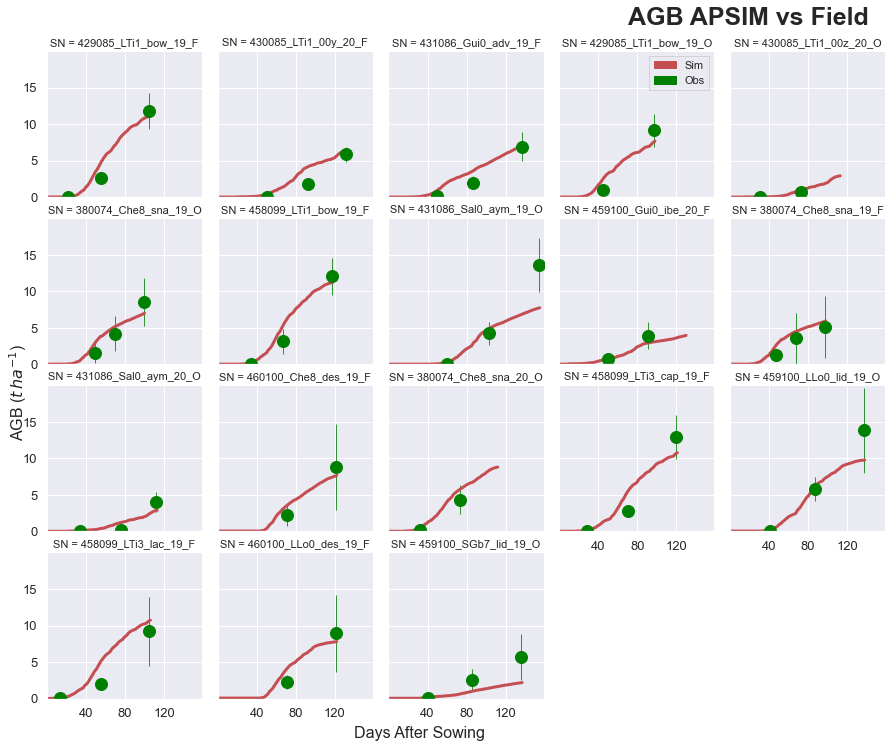

In [96]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "AGB_Pre", linestyle="-",linewidth=3,color='r')
ax = g.map(plt.errorbar, "Das", "AGB_Obs", "AGBError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "AGB_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(2.1, 4.46), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,19.9])

g.fig.text(0.01, 0.43,'AGB ($t\,ha^{-1}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'AGB APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbArg.png', dpi=300,bbox_inches='tight')

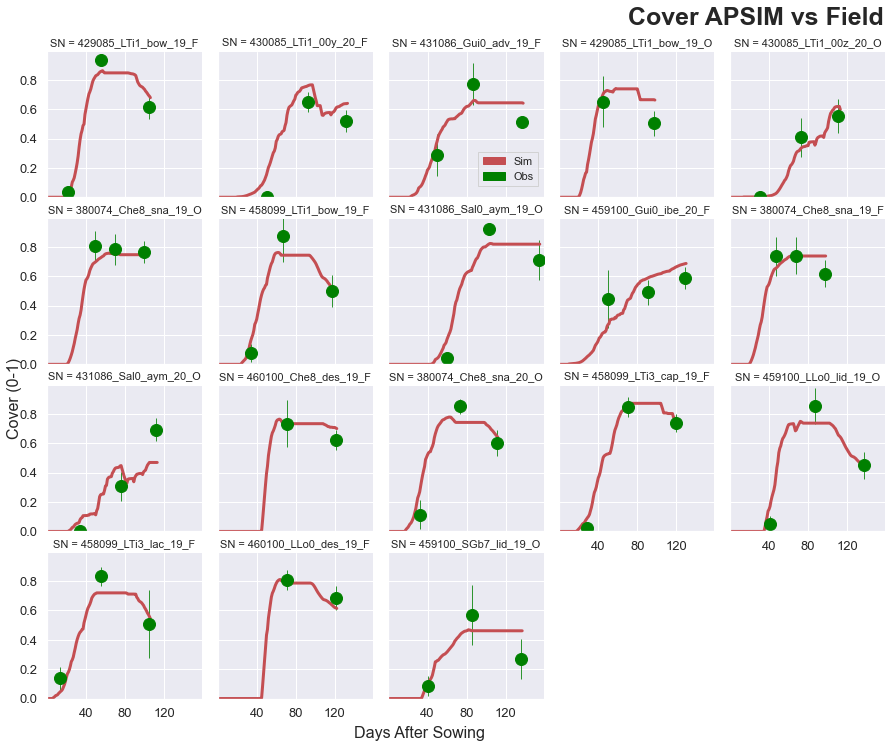

In [97]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "Cover_Pre", linestyle="-",linewidth=3,color='r')
g.map(plt.errorbar, "Das", "Cover_Obs", "CoverError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "Cover_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 3.8), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,0.99])

g.fig.text(0.01, 0.43,'Cover (0-1)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'Cover APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\coverArg.png', dpi=300,bbox_inches='tight')

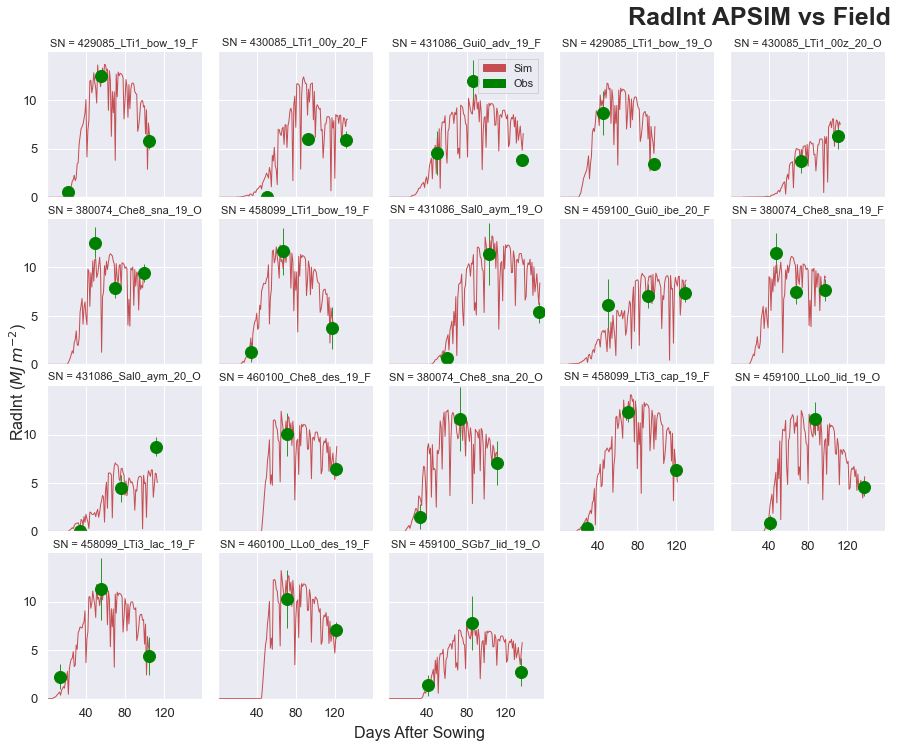

In [98]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "RadInt_Pre", linestyle="-",linewidth=1,color='r')
ax = g.map(plt.errorbar, "Das", "RadInt_Obs", "RadIntError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "RadInt_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,14.99])

g.fig.text(0.01, 0.43,'RadInt ($MJ\,m^{-2}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'RadInt APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\RadArg.png', dpi=300,bbox_inches='tight')

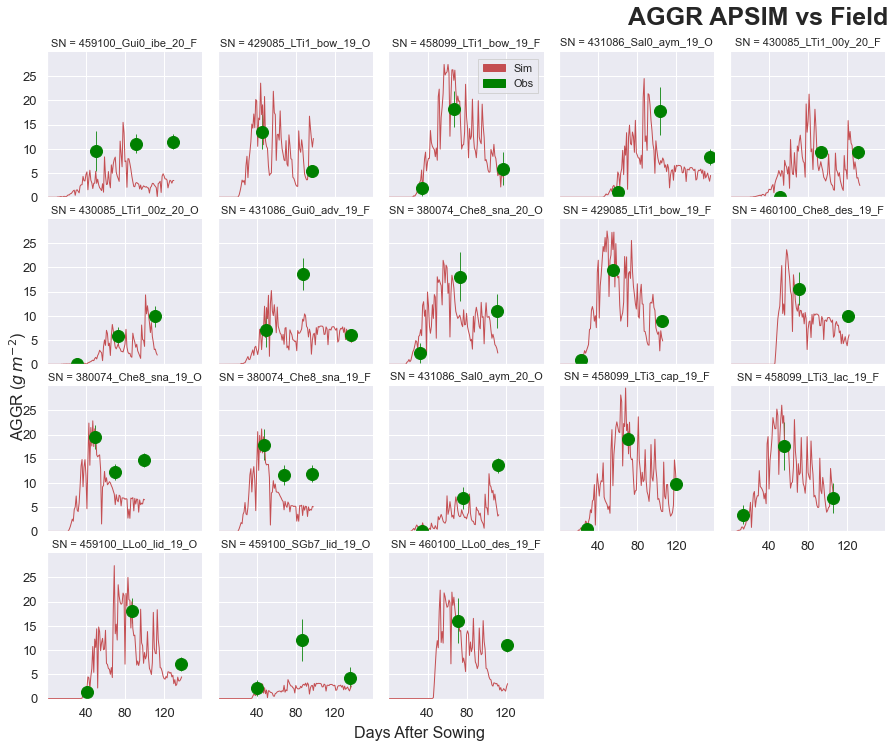

In [87]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "AGGR_Pre", linestyle="-",linewidth=1,color='r')
ax = g.map(plt.errorbar, "Das", "AGGR_Obs", "AGGRError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "AGGR_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,29.99])

g.fig.text(0.01, 0.43,'AGGR ($g\,m^{-2}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'AGGR APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\Python\s2.png', dpi=300,bbox_inches='tight')

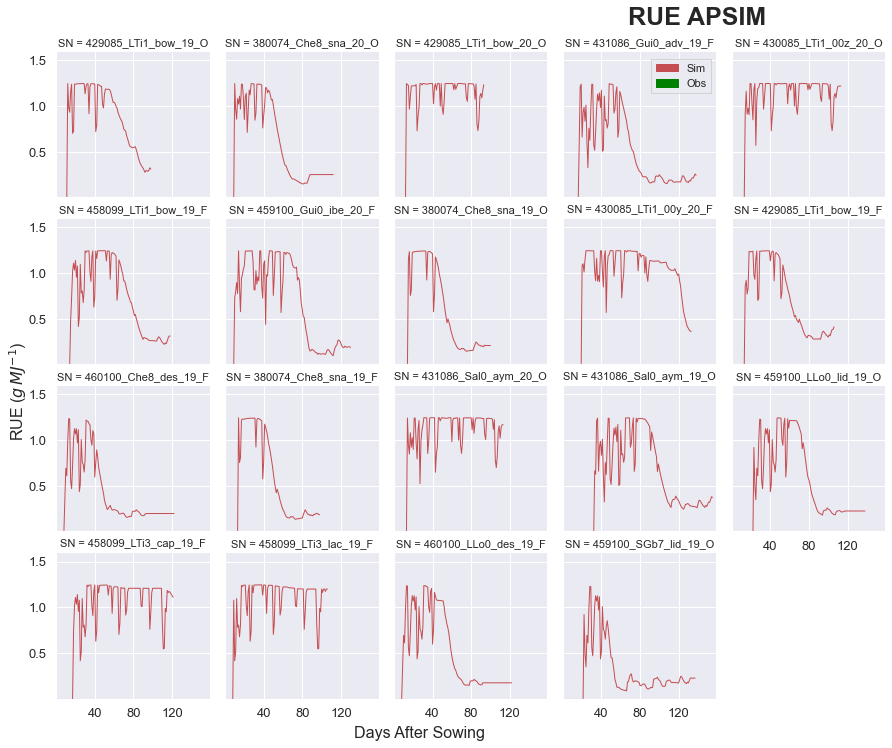

In [47]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_final, col="SN", col_wrap=5, height=2.5, ylim=(0, 15))

g.map(plt.plot, "Das", "RUE_Pre", linestyle="-",linewidth=1,color='r')
#ax = g.map(plt.errorbar, "Das", "RUE_Obs", "RUEError", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
#g.map(plt.plot, "Das", "RUE_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 4.44), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0.01,1.59])

g.fig.text(0.01, 0.43,'RUE ($g\,MJ^{-1}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'RUE APSIM', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rue.png', dpi=300,bbox_inches='tight')

In [58]:
df_finalAus.to_csv(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\0. Calibration\test.csv')

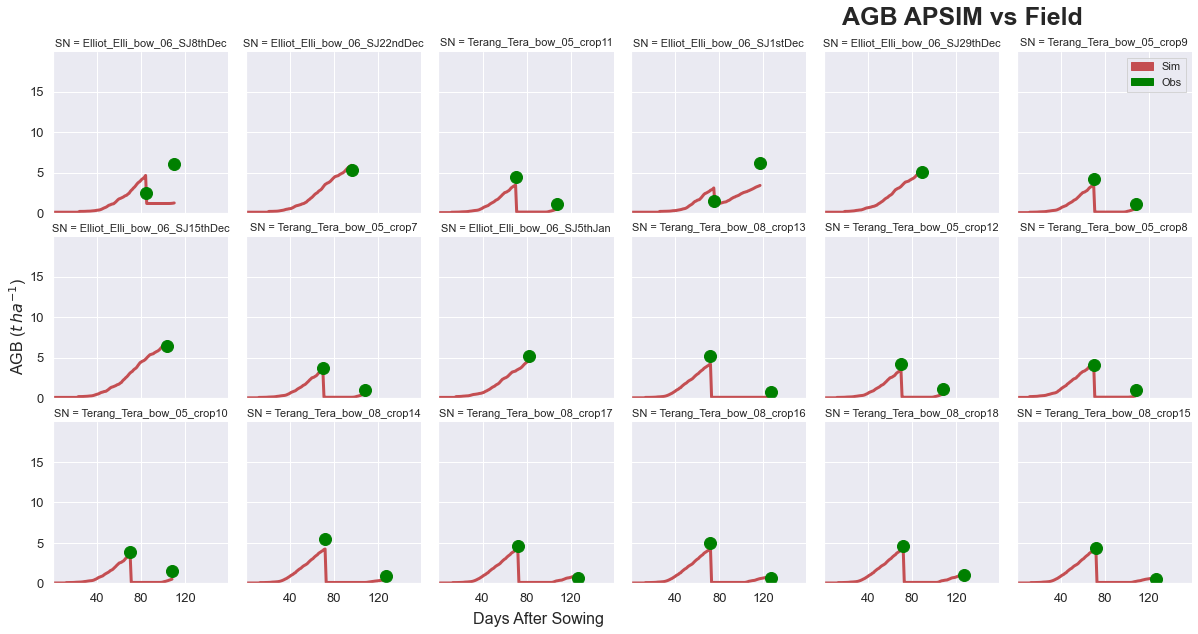

In [99]:
sns.set(font_scale=1)
g = sns.FacetGrid(df_finalAus, col="SN", col_wrap=6, height=2.8, ylim=(0, 15))

g.map(plt.plot, "Das", "AGB_Pre", linestyle="-",linewidth=3,color='r')
ax = g.map(plt.errorbar, "Das", "AGB_Obs", fmt ='o',marker='',zorder=1,color='green',linewidth=0.8)
g.map(plt.plot, "Das", "AGB_Obs", linestyle="",linewidth=3,color='green',marker='o',markersize=12)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Sim')
blue_patch = mpatches.Patch(color='green', label='Obs')
plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 3.3), fancybox=False, shadow=False)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=11)
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,159])
    ax.set_ylim([0,19.9])

g.fig.text(0.01, 0.43,'AGB ($t\,ha^{-1}$)', fontsize=16, rotation=90)
g.fig.text(0.395, 0.01,'Days After Sowing', fontsize=16)
g.fig.text(0.7, 1,'AGB APSIM vs Field', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.15)

#plt.savefig(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbAus.png', dpi=300,bbox_inches='tight')

In [100]:
#Calculate statistics
summ_min = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmin'].mean().round(decimals=1)
summ_max = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmax'].mean().round(decimals=1)
summ_mean = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['tmean'].mean().round(decimals=1)

summ_rain = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['rain'].sum().round(decimals=1)
summ_rad = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['radn'].sum().round(decimals=1)

summ_ET = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], as_index=False)['potentialET'].sum().round(decimals=1)
summ_PAWC = df_final.groupby(['climate', 'soil', 'cultivar', 'harvest', 'prevcrop','SowingDate','RowSpacing',
                              'SowDensity'], as_index=False)['PAWC'].mean().round(decimals=1)

st0 = pd.merge(summ_min, summ_max, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st0.rename(columns={'tmin_x':'tmean_min','tmax_y':'tmean_max'}, inplace=True)

st00 = pd.merge(summ_mean, summ_rain, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st00.rename(columns={'tmean_x':'tmean_mean','rain_y':'rain'}, inplace=True)

st000 = pd.merge(summ_rad, summ_ET, on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'])
st000.rename(columns={'rad_x':'radn','ET_y':'ET'}, inplace=True)

data_frames = [st0, st00, st000, summ_PAWC]
st = reduce(lambda  left,right: pd.merge(left,right,on=['climate', 'soil', 'cultivar', 'harvest', 'prevcrop'], how='outer'), data_frames)
st
#st.to_csv(r'C:\Users\uqjojeda\Google Drive\COALAR\Sorgo\Python\stat.csv', index=None, mode='a')